<a href="https://colab.research.google.com/github/heerboi/AI-from-scratch/blob/main/gpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Following Andrej's video: https://www.youtube.com/watch?v=kCc8FmEb1nY

In [90]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt

--2025-08-20 11:27:55--  https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2025-08-20 11:27:55 (17.6 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [91]:
with open('input.txt', 'r', encoding="utf-8") as f:
    text = f.read()

In [92]:
text[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [93]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [94]:
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s, i in stoi.items()}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: "".join([itos[i] for i in l])

print(encode("Hii"))
print(decode(encode("Hii")))

[20, 47, 47]
Hii


In [95]:
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [96]:
split = int(0.9*len(data))
train_data = data[:split]
val_data = data[split:]
print(len(train_data))
print(len(val_data))

1003854
111540


In [97]:
#context length

block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [98]:
x = train_data[:block_size]
y = train_data[1:block_size+1]

for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(context, target)

tensor([18]) tensor(47)
tensor([18, 47]) tensor(56)
tensor([18, 47, 56]) tensor(57)
tensor([18, 47, 56, 57]) tensor(58)
tensor([18, 47, 56, 57, 58]) tensor(1)
tensor([18, 47, 56, 57, 58,  1]) tensor(15)
tensor([18, 47, 56, 57, 58,  1, 15]) tensor(47)
tensor([18, 47, 56, 57, 58,  1, 15, 47]) tensor(58)


In [99]:
torch.manual_seed(1337)
batch_size = 4
block_size = 8

def get_batch(split):

    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+1+block_size] for i in ix])

    return x, y

x, y = get_batch("train")
print(x)
print(y)

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()

        self.token_embedding_table = nn.Embedding(num_embeddings = vocab_size, embedding_dim = vocab_size)

    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape

            logits = logits.view(B*T, C)
            targets = targets.view(-1)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            # last time step for each batch and include all embeddings
            logits = logits[:, -1, :]

            probabilities = F.softmax(logits, dim=1)
            # (B, 1)
            next_idx = torch.multinomial(probabilities, num_samples=1)
            # (B, T+1)
            idx = torch.cat((idx, next_idx), dim=1)
        return idx

m = BigramLanguageModel(vocab_size)
out, loss = m(x, y)
print(out.shape)
print(out)

print(decode(m.generate(torch.zeros((1,1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

torch.Size([32, 65])
tensor([[ 1.6347, -0.0518,  0.4996,  ...,  0.2432,  1.1519,  0.9950],
        [ 0.3418, -0.9276,  1.2381,  ...,  1.5018, -0.5266,  0.2354],
        [ 0.1479, -0.4333,  0.5203,  ...,  0.3302,  1.5454,  1.3778],
        ...,
        [-0.5693, -0.0735,  0.7743,  ..., -0.0815, -1.1445, -0.0623],
        [ 0.4658, -0.2573, -1.0673,  ...,  1.2439,  1.3471,  1.6910],
        [-0.4553,  0.0139,  0.9309,  ...,  0.0290, -0.7568,  0.8701]],
       grad_fn=<ViewBackward0>)

lfJeukRuaRJKXAYtXzfJ:HEPiu--sDioi;ILCo3pHNTmDwJsfheKRxZCFs
lZJ XQc?:s:HEzEnXalEPklcPU cL'DpdLCafBheH


In [101]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [102]:
batch_size = 32

for steps in range(5000):
    xb,yb = get_batch('train')

    logits, loss = m(xb,yb)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

2.491266965866089


In [103]:
print(decode(m.generate(torch.zeros((1,1), dtype=torch.long), max_new_tokens=1000)[0].tolist()))


Wast, the d f ardotxfe the ge thutheavd to w'd m gararlihe$I'spVandais
NGclo;;

HAWgRhe t sis.
GHashm le yo ctellithed:
Cat rxflyony w p!qMar.
oue, d, h fJfBu nd,
OPYCAr fus y tCg; 'd ladomurdureerawademyg:
SHY:

LCI:
Bisthe thWADI d tounk
WANGENI:ghe iutDoo s spope t hat zous te
THacon b, to--upo WA s sto y: men
We
Old fr3QThaises
O nefr iest ihmeld de anouace y;Gove lsear
Theafrancit.
NI losu mafaspeng
TERut nopretor, metoncKI ainoroe, myd.
Tgklfy wer rrOXDUFk bse ocesen y mC?
I

CAnd elWIsth.
I ollis obaipe OKeorthorot weshithTh.
ABevet wF mis by.
To y,ler Itth my sh
Nq-n ithooRLthajThigh--
ay b.
Gre myr re we.

I avzirthexVI consh, se bor ontheaplyoren iHIVKXThenpkn rk, acathy llved sonk'd?-k'uso z-s grshasun th me yF-amburdasuas beather:
UP chon gie il tKRKath:

NTE:HEEE:
Baigo y pl mpve kist Q:veje bYFle.
OMINor
LAine nd GIUSpldr djTy s
Thes owe, QBHAneanoup oe heotoutho CHE:
k! we; fererima don zl!
w,xxveacur neth bousunem ntaiez;t ngHENG ppptherd my y oue kind
amean oorue retr

In [104]:
eval_iters = 200
@torch.no_grad()
def estimate_loss():
    out = {}
    m.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            xb, yb = get_batch(split)
            logits, loss = m(xb, yb)
            losses[k] = loss.item()
        out[split] = losses.mean()
    m.train()
    return out
estimate_loss()

{'train': tensor(2.5602), 'val': tensor(2.5801)}

## Mathematical trick in self-attention!

- have to average the logits in the time dim 0..t for logit t


In [105]:
B, T, C = 4, 8, 2
x = torch.randn(B,T,C)

In [106]:
div = torch.tril(torch.ones(T,T))
div /= div.sum(dim=1, keepdim=True)
xbow = div @ x

In [107]:
div

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [108]:
x[0], xbow[0]

(tensor([[ 0.1403, -0.0290],
         [ 0.9005,  0.2836],
         [-0.7107, -0.2802],
         [ 1.4693,  0.6379],
         [-0.3859,  1.4116],
         [-0.6111, -1.1886],
         [-0.4339, -0.0700],
         [-0.1715,  0.5119]]),
 tensor([[ 0.1403, -0.0290],
         [ 0.5204,  0.1273],
         [ 0.1100, -0.0085],
         [ 0.4499,  0.1531],
         [ 0.2827,  0.4048],
         [ 0.1337,  0.1392],
         [ 0.0526,  0.1093],
         [ 0.0246,  0.1597]]))

### using softmax(infinity)

hint: e^-infinity = 0, and e^0 = 1

In [109]:
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T, T))
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei,dim=1)
xbow3 = wei @ x
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

## A bit about attention

- Attention is just a mechanism that adds a set of values with a set of weights. The approach above takes the weights to be equally distributed for the node itself and the nodes before, and zero for all nodes after.

- But, the current node might find more of what it needs from some nodes rather than others; it won't necessarily be equally distributed.

- Paper proposes an attention function where each node (token) at time T emits a query vector that contains the information that the current node is looking for, and a key vector that contains the information that the current node has within itself.

- This query vector and key vector get multiplied together to get the "affinities" between what the nodes are looking for and what the nodes have (T, T dimension, so each combination)

- Instead of taking the average of each node, we perform softmax on this new matrix. Now, instead of multiplying the "original" values $x$, we multiply it with the "value" matrix, which is different for each attention "head"

- As each head has a different purpose, it will have a different value to emit in each head, a different value that it posesses that makes more sense for that particular head!

In [110]:
head_size = 16
Q = nn.Linear(C, head_size, bias=False)
K = nn.Linear(C, head_size, bias=False)
V = nn.Linear(C, head_size, bias=False)

queries = Q(x)
keys = K(x)

print(queries.shape)
print(keys.shape)

torch.Size([4, 8, 16])
torch.Size([4, 8, 16])


In [111]:
T

8

In [112]:
tril = torch.tril(torch.ones(T, T))
wei = keys @ queries.transpose(-2, -1) # (4, 8, 8)
# wei = torch.zeros((T, T))
wei1 = wei.masked_fill(tril==0, float('-inf'))
wei1 = F.softmax(wei1, dim=1)
wei = F.softmax(wei,dim=1)

values = V(x)

xbow4 = wei @ values
xbow5 = wei1 @ values
print(wei.shape)
print(xbow4.shape)

torch.Size([4, 8, 8])
torch.Size([4, 8, 16])


In [113]:
wei[0], xbow4[0]

(tensor([[1.3034e-01, 9.7777e-02, 6.5728e-02, 3.8532e-02, 4.6907e-02, 3.3497e-02,
          9.5107e-02, 1.0166e-01],
         [1.3475e-01, 6.9356e-02, 9.2154e-02, 1.7871e-02, 8.8114e-03, 1.3792e-01,
          1.0369e-01, 5.5449e-02],
         [1.2322e-01, 1.2296e-01, 5.1104e-02, 6.9791e-02, 2.9180e-01, 8.2023e-03,
          9.2603e-02, 1.9814e-01],
         [1.3500e-01, 4.4372e-02, 1.3851e-01, 7.2671e-03, 2.3898e-03, 4.9373e-01,
          1.2049e-01, 3.4751e-02],
         [9.2688e-02, 9.1358e-03, 4.3625e-01, 7.5236e-04, 7.1513e-02, 2.4623e-01,
          2.9044e-01, 1.2821e-01],
         [1.4848e-01, 5.2391e-01, 1.5794e-02, 8.1641e-01, 3.5730e-01, 1.7959e-03,
          4.7736e-02, 2.0377e-01],
         [1.2244e-01, 9.3229e-02, 6.5405e-02, 4.0686e-02, 1.5209e-01, 1.6325e-02,
          1.0233e-01, 1.5718e-01],
         [1.1309e-01, 3.9264e-02, 1.3505e-01, 8.6923e-03, 6.9186e-02, 6.2312e-02,
          1.4760e-01, 1.2084e-01]], grad_fn=<SelectBackward0>),
 tensor([[ 4.5081e-02,  4.1569e-02,

In [114]:
wei1[0], xbow5[0]

(tensor([[1.3034e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.3475e-01, 7.6873e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.2322e-01, 1.3628e-01, 6.0685e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.3500e-01, 4.9181e-02, 1.6448e-01, 8.3167e-03, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [9.2688e-02, 1.0126e-02, 5.1804e-01, 8.6101e-04, 1.1000e-01, 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.4848e-01, 5.8069e-01, 1.8755e-02, 9.3431e-01, 5.4962e-01, 2.2328e-02,
          0.0000e+00, 0.0000e+00],
         [1.2244e-01, 1.0333e-01, 7.7668e-02, 4.6562e-02, 2.3395e-01, 2.0296e-01,
          4.0943e-01, 0.0000e+00],
         [1.1309e-01, 4.3520e-02, 1.6037e-01, 9.9476e-03, 1.0643e-01, 7.7471e-01,
          5.9057e-01, 1.0000e+00]], grad_fn=<SelectBackward0>),
 tensor([[ 3.5628e-03,  8.0178e-03,

there's a little problem tho

In [115]:
query = torch.randn((4, 8, 16))
key = torch.randn((4, 8, 16))

print(query.var())
print(key.var())

tensor(0.9601)
tensor(0.8890)


In [116]:
qk = key @ query.transpose(-2, -1)
print(qk.var())

tensor(14.1292)


HUGE difference in variance, and when variance is high, means the difference between the values is huge. Since we'll apply softmax on this, if the values are very imbalanced, there'll be a huge imbalance in the weight assigned to other nodes, esp when the network is still untrained.

The paper proposes dividing the multiplication by the square root of head size, let's try it.

In [117]:
qk = key @ query.transpose(-2, -1) * head_size**-0.5
print(qk.var())

tensor(0.8831)


looks good

In [118]:
# num of attn heads running in parallel
n_heads = 8
# embedding size
# all layer final outputs must match 256
n_embd = 256

# individual heads are concat at the end
head_size = n_embd // n_heads

# size of ffn hidden layer
hidden_size = 512

# total number of stacked transformer blocks
n_blocks = 4

In [119]:
class SingleAttentionHead(nn.Module):

    def __init__(self):
        super().__init__()
        self.Q = nn.Linear(n_embd, head_size, bias=False)
        self.K = nn.Linear(n_embd, head_size, bias=False)
        self.V = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        # (B, T, head_size)
        queries = self.Q(x)
        keys = self.K(x)
        values = self.V(x)

        wei = keys @ queries.transpose(-2, -1) * head_size ** -0.5
        wei = wei.masked_fill(self.tril == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)

        x = wei @ values
        return x

class FFN(nn.Module):

    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.layers = nn.Sequential(
            # op: (B, T, hidden_size)
            nn.Linear(in_features, hidden_size, bias=bias),
            nn.ReLU(),
            # op: (B, T, n_embd)
            nn.Linear(hidden_size, out_features, bias=bias),
            nn.LayerNorm(out_features)
        )

    def forward(self, x):
        out = x + self.layers(x)
        return out

In [120]:
class MultiAttentionBlock(nn.Module):

    def __init__(self):
        super().__init__()
        self.heads = [SingleAttentionHead() for _ in range(n_heads)]

        self.linear = nn.Linear(n_embd, n_embd)

        self.layer_norm = nn.LayerNorm(n_embd)

    def forward(self, x):
        # each op: (B, T, head_size)
        act = [head(x) for head in self.heads]
        # op: (B, T, n_embd)
        out = x + self.layer_norm(self.linear(torch.concat(act, dim=-1)))

        return out

class DecoderBlock(nn.Module):
    def __init__(self):
        super().__init__()

        self.multi_attention_block = MultiAttentionBlock()
        self.ffn = FFN(n_embd, n_embd)

    def forward(self, x):
        x = self.ffn(self.multi_attention_block(x))

        return x

In [121]:
def positional_embed(seq_len, n_embd):
    pe = torch.zeros(seq_len, n_embd)

    position = torch.arange(0, seq_len).unsqueeze(1).float()
    even = torch.arange(0,n_embd,2).float()

    pe[:, 0::2] = torch.sin(position / 10000**(2*even/n_embd))
    pe[:, 1::2] = torch.cos(position / 10000**((2*even+1)/n_embd))
    return pe

In [122]:
class Decoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.token_embedding_table = nn.Embedding(num_embeddings=vocab_size, embedding_dim=n_embd)
        self.position_embedding_table = positional_embed(block_size, n_embd)
        # self.lm_head = SingleAttentionHead(head_size)
        # self.ffn = FFN(head_size, hidden_size)
        # self.attention_block = SingleAttentionBlock(head_size, hidden_size)

        # inp: (B, T, n_embd)
        # op:  (B, T, n_embd)
        # self.multi_head_attn = MultiAttentionBlock()

        # self.ffn = FFN(n_embd, n_embd)
        # pairs of multi head self attn blocks + ffn in sequence
        self.decoder_block = nn.Sequential(*[DecoderBlock() for _ in range(n_blocks)])

        self.nn = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_embd = self.token_embedding_table(idx)
        pos_embd = self.position_embedding_table

        x = tok_embd + pos_embd
        # x = self.lm_head(x)
        # x = self.ffn(x)
        # x = self.attention_block(x)
        # residual connections moved to their respective classes
        x = self.decoder_block(x)

        logits = self.nn(x)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape

            logits = logits.view(B*T, C)
            targets = targets.view(-1)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            # pick only last 8 tokens for next token
            idx_next = idx[:, -block_size:]
            logits, loss = self(idx_next)
            # last time step for each batch and include all embeddings
            logits = logits[:, -1, :]

            probabilities = F.softmax(logits, dim=1)
            # (B, 1)
            next_idx = torch.multinomial(probabilities, num_samples=1)
            # (B, T+1)
            idx = torch.cat((idx, next_idx), dim=1)
        return idx

In [123]:
xb, yb = get_batch('train')

In [130]:
m = Decoder()
out, loss = m(xb, yb)
print(out.shape)
print(out)
print("Total parameters:")
print(sum([p.nelement() for p in m.parameters()]))

print(decode(m.generate(torch.zeros((1,8), dtype=torch.long), max_new_tokens=100)[0].tolist()))

torch.Size([4096, 65])
tensor([[ 1.3846,  0.1480,  2.0639,  ..., -0.9663, -2.5792,  2.2899],
        [ 1.3383,  1.5869,  2.9768,  ..., -0.0420, -1.0228, -0.5101],
        [ 0.2080, -1.2150,  0.3590,  ...,  0.9509, -1.3939,  0.6124],
        ...,
        [ 1.4560, -0.1211,  2.1260,  ..., -1.2666, -1.7726,  3.1364],
        [ 1.9481,  3.0142, -0.1396,  ..., -1.7446, -1.3527,  1.6952],
        [ 0.6928,  0.7442,  1.5399,  ..., -1.7575, -1.3008,  1.1325]],
       grad_fn=<ViewBackward0>)
Total parameters:
1352257








vbEbScSbGFGbT
v$QVbQCbSSbrS:ZZKSbkSSvFbP,uSv:YuTKWSFCSV:Z,KSScS:Z.CS!M-ZvSKTbSuI-SubqK?v?bSbbkK-:FCS


In [131]:
optimizer = torch.optim.AdamW(m.parameters(), lr=5e-3)

In [132]:
batch_size = 512

for steps in range(2500):
    xb,yb = get_batch('train')

    logits, loss = m(xb,yb)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    if steps % 100 == 0:
        print(f"Loss at {steps}: {loss.item()}")

Loss at 0: 6.1375322341918945
Loss at 100: 2.451122760772705
Loss at 200: 2.356013774871826
Loss at 300: 2.2939491271972656
Loss at 400: 2.147066116333008
Loss at 500: 2.0996806621551514
Loss at 600: 2.0396978855133057
Loss at 700: 1.9509673118591309
Loss at 800: 1.9052704572677612
Loss at 900: 1.9128633737564087
Loss at 1000: 1.8592967987060547
Loss at 1100: 1.8319675922393799
Loss at 1200: 1.8313820362091064
Loss at 1300: 1.7785439491271973
Loss at 1400: 1.792030692100525
Loss at 1500: 1.769928216934204
Loss at 1600: 1.7452094554901123
Loss at 1700: 1.7706327438354492
Loss at 1800: 1.7523645162582397
Loss at 1900: 1.748564600944519
Loss at 2000: 1.751305103302002
Loss at 2100: 1.7704108953475952
Loss at 2200: 1.7309626340866089
Loss at 2300: 1.7437273263931274
Loss at 2400: 1.724327564239502


training a bit longer bec loss still decreasing

In [129]:
batch_size = 512

for steps in range(500):
    xb,yb = get_batch('train')

    logits, loss = m(xb,yb)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    if steps % 100 == 0:
        print(f"Loss at {steps}: {loss.item()}")

Loss at 0: 1.8207427263259888
Loss at 100: 1.7284832000732422
Loss at 200: 1.7249070405960083
Loss at 300: 1.7687430381774902
Loss at 400: 1.7452877759933472


In [133]:
estimate_loss()

{'train': tensor(1.7195), 'val': tensor(1.8767)}

* transformer with single attention block, no layer norm, and no ffn: train 2.3442 val: 2.3719
* transformer with single attn, layer norm and ffn, no residual connection: train 2.2628 val 2.3023

* transformer with multi head attn + linear, layer norm, ffn and residual connection in after multihead attn: train 1.7584 val 1.9072

* transformer with multiple stacked attention-ffn blocks!: train 1.65 val 1.82

* using sinusoidal positional embedding converges much faster!! train 1.71 val 1.87

In [134]:
print(decode(m.generate(torch.zeros((1,8), dtype=torch.long), max_new_tokens=1000)[0].tolist())[8:])

QUEEEN EEL:
My Goveruo for certoclident return rather, agreeth Good loving from to his poisontess face,
Or oo your forbids to embrave other;
For I sin to your have
that in his no merrose beforewers.

Might of this segand to the fault thus that chareful, roef's
so to your flowed of you out
so, 'to virsueds contenting as fore'er light, if Bountry
Clibe bucked to

they palighter befter upar good What not
To didshod:
We shadved despared he have touch Sold,
He knows act made
sped people, my souse we'll 'tis a powerful.

My cause tentey millate kellies, since now, dear! O, Pacians, dog
Artiuse the forwert the Duke me authsurden thou sast my an with you to fale shall mong how some detedly
Of hath a genelso.

ANGELO:
I know this shall deind is 'gaons' there most do to selven
To dire--day;
Be fareels of me,
No. Were a my poor for I as trive the fall morse of wretchess fair
Ted, but subject on me;
'Tis of Gresent my stertess
Or that judgment his face,
You made!
That jog not deat,
And vial fayful

## positional encoding


In [35]:
from math import sin, cos

In [73]:
i = list(range(1,51))
pos = list(range(1,9))
embeddings = {n:[] for n in pos}
embeddings_no_div = {n:[] for n in pos}
for p in pos:
    for num in i:
        if num % 2 == 0:
            embed = sin(p)
            div_embed = sin(p/10000**(-2*num/512))
        else:
            embed = cos(p)
            div_embed = cos(p/10000**(-2*num/512))
        embeddings_no_div[p].append(embed)
        embeddings[p].append(div_embed)

In [66]:
sin(1)

0.8414709848078965

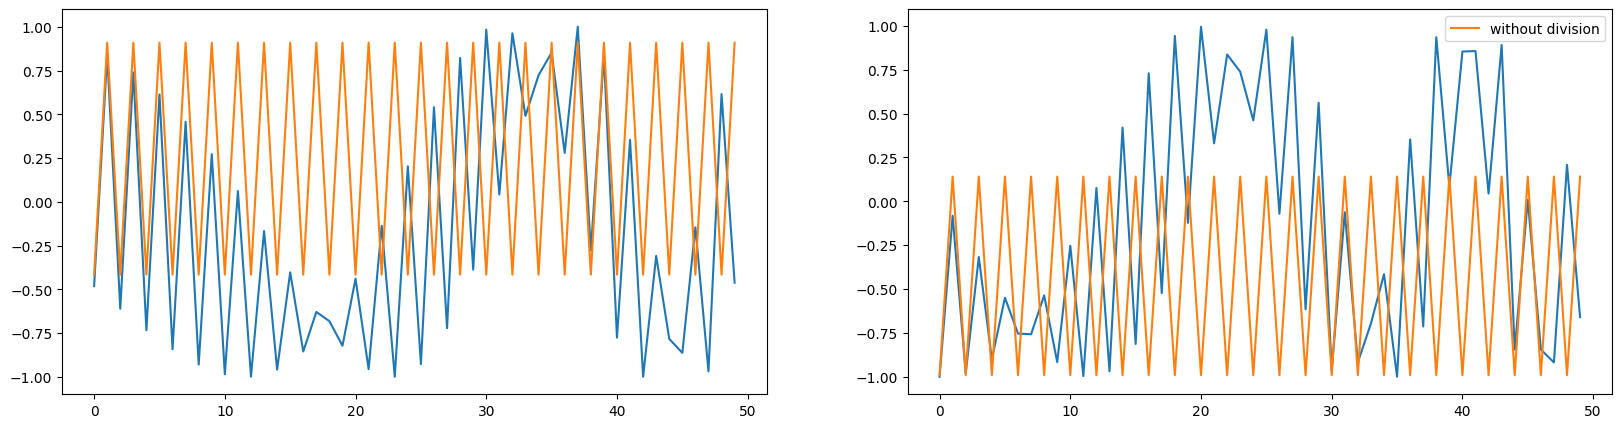

In [74]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 5)
ax[0].plot(embeddings[2])
ax[0].plot(embeddings_no_div[2], label = "Without division")
# ax[0].plot(embeddings[6])
ax[1].plot(embeddings[3])
ax[1].plot(embeddings_no_div[3], label = "without division")
# ax[1].plot(embeddings[5])
# plt.plot([e for e in embeddings.values()],label = [f"Pos{i}" for i in embeddings.keys()])
plt.legend()
plt.show()

In [75]:
xb

tensor([[31, 43, 41, 53, 52, 42,  1, 25],
        [61, 52,  1, 41, 46, 53, 47, 41],
        [ 1, 51, 63,  1, 50, 47, 43, 45],
        [58, 46, 43, 43,  1, 58, 53,  1],
        [44, 47, 56, 43, 12,  0, 17, 42],
        [ 0, 28, 13, 33, 24, 21, 26, 13],
        [43, 47, 60, 43,  5, 57,  1, 47],
        [44, 39, 41, 43,  6,  0, 32, 46],
        [ 1, 60, 47, 53, 50, 43, 52, 58],
        [39, 52, 52, 43, 57, 57,  6,  1],
        [33, 25, 14, 17, 30, 24, 13, 26],
        [ 8,  0, 31, 47, 56,  6,  1, 58],
        [46,  1, 57, 53,  1, 50, 53, 52],
        [59, 58,  1, 52, 53, 58,  1, 41],
        [57, 58,  1, 46, 43,  1, 58, 46],
        [58,  1, 42, 39, 63, 57,  6,  1],
        [45, 43, 58,  1, 58, 46, 43, 43],
        [57, 58, 63,  8,  0,  0, 35, 13],
        [56, 52,  8,  0, 28, 43, 56, 41],
        [39,  1, 40, 50, 53, 61,  8,  0],
        [58,  1, 58, 46, 53, 59,  1, 58],
        [16, 33, 23, 17,  1, 34, 21, 26],
        [59,  1, 46, 53, 51, 43,  1, 58],
        [47, 52, 42,  0, 37, 53, 5

In [79]:
torch.arange(0, 5).unsqueeze(1).shape

torch.Size([5, 1])

In [81]:
even = torch.arange(0,n_embd,2).float()
even+1

tensor([  1.,   3.,   5.,   7.,   9.,  11.,  13.,  15.,  17.,  19.,  21.,  23.,
         25.,  27.,  29.,  31.,  33.,  35.,  37.,  39.,  41.,  43.,  45.,  47.,
         49.,  51.,  53.,  55.,  57.,  59.,  61.,  63.,  65.,  67.,  69.,  71.,
         73.,  75.,  77.,  79.,  81.,  83.,  85.,  87.,  89.,  91.,  93.,  95.,
         97.,  99., 101., 103., 105., 107., 109., 111., 113., 115., 117., 119.,
        121., 123., 125., 127., 129., 131., 133., 135., 137., 139., 141., 143.,
        145., 147., 149., 151., 153., 155., 157., 159., 161., 163., 165., 167.,
        169., 171., 173., 175., 177., 179., 181., 183., 185., 187., 189., 191.,
        193., 195., 197., 199., 201., 203., 205., 207., 209., 211., 213., 215.,
        217., 219., 221., 223., 225., 227., 229., 231., 233., 235., 237., 239.,
        241., 243., 245., 247., 249., 251., 253., 255.])

In [82]:
def positional_embed(seq_len, n_embd):
    pe = torch.zeros(seq_len, n_embd)

    position = torch.arange(0, seq_len).unsqueeze(1).float()
    even = torch.arange(0,n_embd,2).float()

    pe[:, 0::2] = torch.sin(position / 10000**(2*even/n_embd))
    pe[:, 1::2] = torch.cos(position / 10000**((2*even+1)/n_embd))
    return pe

In [83]:
positional_embed(8,8)

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  9.5042e-01,  9.9998e-03,  9.9999e-01,  1.0000e-04,
          1.0000e+00,  1.0000e-06,  1.0000e+00],
        [ 9.0930e-01,  8.0658e-01,  1.9999e-02,  9.9998e-01,  2.0000e-04,
          1.0000e+00,  2.0000e-06,  1.0000e+00],
        [ 1.4112e-01,  5.8275e-01,  2.9995e-02,  9.9995e-01,  3.0000e-04,
          1.0000e+00,  3.0000e-06,  1.0000e+00],
        [-7.5680e-01,  3.0114e-01,  3.9989e-02,  9.9992e-01,  4.0000e-04,
          1.0000e+00,  4.0000e-06,  1.0000e+00],
        [-9.5892e-01, -1.0342e-02,  4.9979e-02,  9.9988e-01,  5.0000e-04,
          1.0000e+00,  5.0000e-06,  1.0000e+00],
        [-2.7942e-01, -3.2080e-01,  5.9964e-02,  9.9982e-01,  6.0000e-04,
          1.0000e+00,  6.0000e-06,  1.0000e+00],
        [ 6.5699e-01, -5.9944e-01,  6.9943e-02,  9.9976e-01,  7.0000e-04,
          1.0000e+00,  7.0000e-06,  1.0000e+00]])